In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [82]:
# Circle: returns true if (px, py) is inside the circle of radius r centered at (cx, cy)
circle_mask(px, py, cx, cy, r) = (px - cx)^2 + (py - cy)^2 <= r^2

# Cross: returns true if (px, py) is within the cross arms centered at (cx, cy) with arm length size and thickness t
function cross_mask(px, py, cx, cy, size, t)
    half = size / 2
    # Horizontal arm
    in_h = abs(py - cy) <= t/2 && abs(px - cx) <= half
    # Vertical arm
    in_v = abs(px - cx) <= t/2 && abs(py - cy) <= half
    return in_h || in_v
end

# Rasterize a random shape to a grid array
function raster_random_shape(rng::AbstractRNG; canvas_size=10, grid_size=128, cross_thickness=0.2)
    shape_type = rand(rng, ["cross", "circle"])
    vmap = Dict("cross" => 1, "circle" => 2)
    x = rand(rng) * canvas_size
    y = rand(rng) * canvas_size
    size = (0.5 + rand(rng)) * (canvas_size / 5)
    t = cross_thickness * size

    # Set up grid coordinates (center of each pixel)
    xs = range(0, canvas_size, length=grid_size)
    ys = range(0, canvas_size, length=grid_size)
    img = zeros(Float32, grid_size, grid_size, 1)

    for j in 1:grid_size, i in 1:grid_size
        px, py = xs[i], ys[j]
        if shape_type == "circle"
            img[j, i, 1] = circle_mask(px, py, x, y, size/2) ? 1 : 0
        else
            img[j, i, 1] = cross_mask(px, py, x, y, size, t) ? 1 : 0
        end
    end
    return img, vmap[shape_type]
end

raster_random_shape (generic function with 1 method)

In [133]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [ ]:
args = Args(batchsize = 128, epochs = 25)

Args(0.0003, 128, 25, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [175]:
function generate_dataset(rng::AbstractRNG, n::Int, args::Args)
    data = [raster_random_shape(rng) for i in 1:n];
    x = stack([d[1] for d in data]);
    y = onehotbatch(stack([d[2] for d in data]), 1:2);
    loader = DataLoader((x, y), batchsize = args.batchsize)
    return loader
end

generate_dataset (generic function with 1 method)

In [134]:
data = [raster_random_shape(rng) for i in 1:10000];

In [135]:
x = stack([d[1] for d in data]);

In [136]:
size(x)

(128, 128, 1, 10000)

In [139]:
y = onehotbatch(stack([d[2] for d in data]), 1:2);

In [ ]:
size(y)

(2, 10000)

In [149]:
train_loader = DataLoader((x, y), batchsize = args.batchsize)

79-element DataLoader(::Tuple{Array{Float32, 4}, OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=128)
  with first element:
  (128×128×1×128 Array{Float32, 4}, 2×128 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [150]:
x0, y0 = first(train_loader)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 1 1 … 1 1])

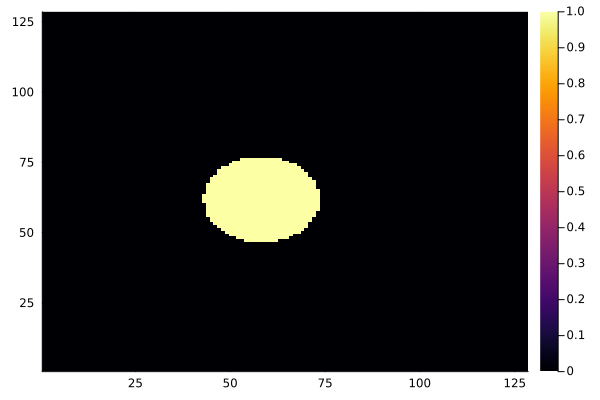

In [151]:
heatmap(x0[:,:,1,1])

In [152]:
y0[:,1]

2-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 1

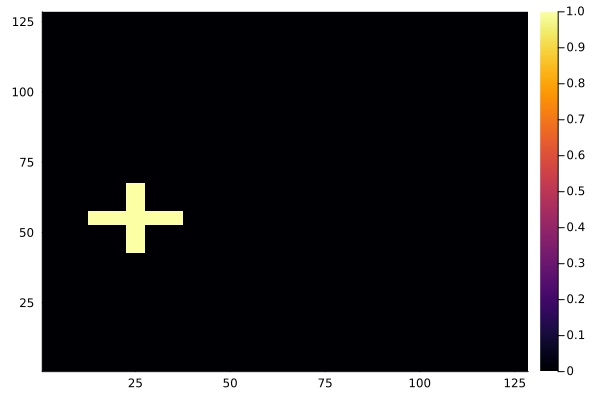

In [153]:
heatmap(x0[:,:,1,5])

In [154]:
y0[:,5]

2-element OneHotVector(::UInt32) with eltype Bool:
 1
 ⋅

In [155]:
model = Chain(Conv((32,32), 1=>3, relu, pad=(1,1)),
            MaxPool((2,2)),
            Dropout(0.3),

            Conv((16,16), 3=>1, relu, pad=(1,1)),
            MaxPool((2,2)),
            FlattenLayer(),
            Dropout(0.4),

            Dense(324 => 16, relu),
            Dense(16 => 2),
            softmax)

Chain(
    layer_1 = Conv((32, 32), 1 => 3, relu, pad=1),  # 3_075 parameters
    layer_2 = MaxPool((2, 2)),
    layer_3 = Dropout(0.3),
    layer_4 = Conv((16, 16), 3 => 1, relu, pad=1),  # 769 parameters
    layer_5 = MaxPool((2, 2)),
    layer_6 = FlattenLayer{Nothing}(nothing),
    layer_7 = Dropout(0.4),
    layer_8 = Dense(324 => 16, relu),   # 5_200 parameters
    layer_9 = Dense(16 => 2),           # 34 parameters
    layer_10 = WrappedFunction(softmax),
)         # Total: 9_078 parameters,
          #        plus 4 states.

In [156]:
ps, st = Lux.setup(rng, model) .|> gdev

((layer_1 = (weight = Float32[-0.026775658 0.06082791 … -0.07906008 -0.009120998; 0.08067051 -0.054876134 … -0.0914197 -0.07923811; … ; 0.05434433 0.0048649358 … 0.022432618 -0.10631033; 0.040689804 0.03590374 … 0.009264409 0.037857823;;;; -0.08492286 0.08936507 … -0.053798042 -0.06083718; 0.056935545 -0.045121424 … -0.042384524 0.053189144; … ; 0.030848473 -0.10203086 … -0.072675005 0.10319626; 0.06214682 0.058298524 … -0.044514213 -0.0019160378;;;; 0.082510546 0.025232157 … 0.05275949 0.024172235; -0.08932006 -0.057845205 … -0.04925729 -0.09249155; … ; -0.023808036 -0.064633094 … -0.09617268 -0.10186189; -0.029787906 -0.06139398 … 0.107496254 0.03687022], bias = Float32[0.01757368, 0.02166593, 0.014714334]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.016180396 0.08117725 … 0.05431904 0.06116289; 0.02939488 -0.12455152 … 0.046144754 -0.041634858; … ; 0.10046832 -0.027059361 … -0.055766523 -0.06652102; -0.011402503 -0.027853057 … -0.0813812 -0.0935458

In [157]:
x0 = x0 |> gdev
y0 = y0 |> gdev

2×128 OneHotMatrix(::CuArray{UInt32, 1, CUDA.DeviceMemory}) with eltype Bool:
 ⋅  ⋅  1  1  1  1  1  1  ⋅  ⋅  ⋅  1  ⋅  …  1  1  1  1  1  1  ⋅  1  ⋅  1  ⋅  ⋅
 1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  1  1

In [158]:
yh0, _ = model(x0, ps, st)

(Float32[0.94259065 0.98759925 … 0.45830515 0.7111583; 0.05740931 0.012400685 … 0.5416949 0.28884175], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (rng = Xoshiro(0x960e7e8b9502539e, 0x0449c91c6835bd3e, 0x04e83ce4b85b4e13, 0xf35ff5d91ced8001, 0xc90c4a0730db3f7e), training = Val{true}()), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple(), layer_7 = (rng = Xoshiro(0x6118424ee1da6ea1, 0x96af8b73456ca0b3, 0x00de920457251d8d, 0x07a7fee2c798ae9b, 0xc90c4a0730db3f7e), training = Val{true}()), layer_8 = NamedTuple(), layer_9 = NamedTuple(), layer_10 = NamedTuple()))

In [159]:
size(yh0)

(2, 128)

In [161]:
CrossEntropyLoss(; logits=false)(yh0, y0)

0.91013837f0

In [162]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y)
end

loss_function (generic function with 1 method)

In [163]:
l, gs = withgradient(p -> loss_function(x0, y0, model, p, st), ps)

(val = 0.91013837f0, grad = ((layer_1 = (weight = Float32[0.013101293 0.0059055192 … -0.0030118995 -0.0008872112; 0.010515493 0.008306538 … -0.002629987 -0.00065955764; … ; -0.0013182065 -0.0062548835 … 0.05539137 0.05858335; -0.016011078 -0.018100724 … 0.054553162 0.051882282;;;; 0.0050787586 0.016589768 … 0.06314291 0.039353505; 0.005432987 0.004860038 … 0.054964982 0.050837576; … ; 0.0011441396 -0.0028222534 … 0.04742782 0.05591904; 0.006764099 0.0026063165 … 0.050048575 0.050980248;;;; 0.008621792 0.0085801985 … 0.03536276 0.041028515; 0.0074720094 0.0075786184 … 0.030433957 0.04008934; … ; 0.005026429 0.0033718897 … 0.06835222 0.05316062; 0.0029514027 -0.00020557549 … 0.068880096 0.05599816], bias = Float32[0.05839043, 0.03503021, 0.10644994]), layer_2 = nothing, layer_3 = nothing, layer_4 = (weight = Float32[0.03197728 0.05007463 … 0.024757545 0.01803295; 0.030441456 0.046465643 … 0.014251232 0.028171174; … ; 0.013839149 0.02056169 … 0.0052576736 -0.0029882786; 0.023176344 0.0284

In [166]:
opt = Optimisers.Adam(args.η)
opt_state = Optimisers.setup(opt, ps)

(layer_1 = (weight = Leaf(Adam(eta=0.0003, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(eta=0.0003, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0], (0.9, 0.999)))), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Leaf(Adam(eta=0.0003, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 

In [167]:
opt_state, ps1 = Optimisers.update(opt_state, ps, gs[1])

((layer_1 = (weight = Leaf(Adam(eta=0.0003, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.00131013 0.000590552 … -0.00030119 -8.87211f-5; 0.00105155 0.000830654 … -0.000262999 -6.59558f-5; … ; -0.000131821 -0.000625489 … 0.00553914 0.00585834; -0.00160111 -0.00181007 … 0.00545532 0.00518823;;;; 0.000507876 0.00165898 … 0.00631429 0.00393535; 0.000543299 0.000486004 … 0.0054965 0.00508376; … ; 0.000114414 -0.000282225 … 0.00474278 0.00559191; 0.00067641 0.000260632 … 0.00500486 0.00509803;;;; 0.000862179 0.00085802 … 0.00353628 0.00410285; 0.000747201 0.000757862 … 0.0030434 0.00400893; … ; 0.000502643 0.000337189 … 0.00683522 0.00531606; 0.00029514 -2.05576f-5 … 0.00688801 0.00559982], Float32[1.71642f-7 3.48747f-8 … 9.07142f-9 7.87134f-10; 1.10574f-7 6.89977f-8 … 6.91674f-9 4.35011f-10; … ; 1.73765f-9 3.91231f-8 … 3.06816f-6 3.43196f-6; 2.56351f-7 3.27632f-7 … 2.97601f-6 2.69174f-6;;;; 2.57935f-8 2.75217f-7 … 3.98698f-6 1.54868f-6; 2.9517f-8 2.36197f-8 … 3.02111f-6 2.58443f-6; … ; 1.

In [168]:
losses, pst, stt = train(model, ps, st, train_loader, loss_function, args)

[ Info: Training on CUDA GPU


(Any[0.91013837f0, 0.89028835f0, 0.98117924f0, 0.86235285f0, 0.8696811f0, 0.7581576f0, 0.80359936f0, 0.8699492f0, 0.8049074f0, 0.7273389f0  …  0.010137027f0, 0.0105109f0, 0.013962468f0, 0.021529045f0, 0.013970923f0, 0.011823488f0, 0.011834286f0, 0.0130013f0, 0.01625952f0, 0.007317638f0], (layer_1 = (weight = Float32[-0.034638718 0.07550893 … -0.1303151 -0.005764698; 0.07565549 0.048133336 … -0.145672 -0.029744841; … ; 0.026957143 0.01819325 … 0.008709773 -0.10111998; -0.000707115 0.0056506773 … -0.0013608747 0.0028441849;;;; -0.1238514 0.055960253 … -0.074739985 -0.04378136; 0.036867954 -0.044214148 … -0.051400833 0.0787051; … ; -0.019686634 -0.09687882 … -0.0951041 0.08109805; 0.010160166 0.02501208 … -0.06949356 -0.02064637;;;; 0.080651164 0.04256762 … 0.09352735 0.07500895; -0.072745904 -0.0029691376 … -0.021012053 -0.052415032; … ; -0.0054568835 -0.04504397 … -0.077860355 -0.07036956; -0.02834436 -0.035684325 … 0.09502266 0.028595421], bias = Float32[0.007180023, -0.0017555414, 0.0

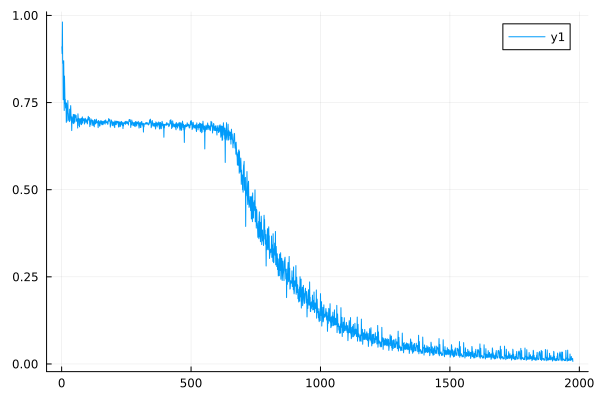

In [169]:
plot(losses)

In [170]:
yh1, _ = model(x0, pst, stt)

(Float32[1.61f-43 6.7826345f-34 … 2.8593215f-12 4.7033404f-6; 1.0 1.0 … 1.0 0.99999535], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (rng = Xoshiro(0x960e7e8b9502539e, 0x0449c91c6835bd3e, 0x04e83ce4b85b4e13, 0xf35ff5d91ced8001, 0xc90c4a0730db3f7e), training = Val{true}()), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple(), layer_7 = (rng = Xoshiro(0x6118424ee1da6ea1, 0x96af8b73456ca0b3, 0x00de920457251d8d, 0x07a7fee2c798ae9b, 0xc90c4a0730db3f7e), training = Val{true}()), layer_8 = NamedTuple(), layer_9 = NamedTuple(), layer_10 = NamedTuple()))

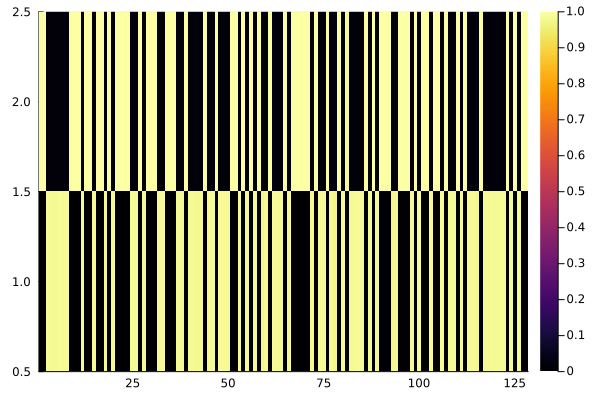

In [173]:
heatmap(yh1 |> cdev)

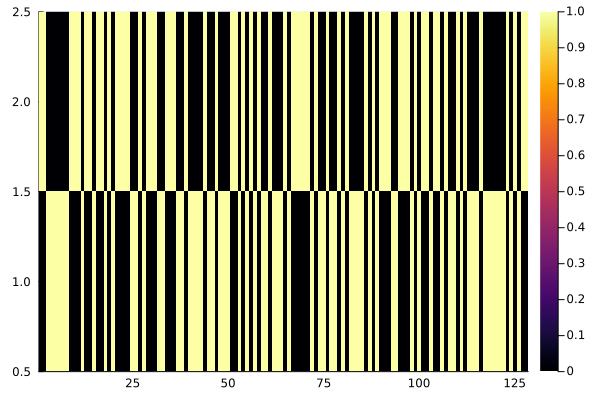

In [174]:
heatmap(y0 |> cdev)

In [176]:
test_loader = generate_dataset(rng, 1000, args)

8-element DataLoader(::Tuple{Array{Float32, 4}, OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=128)
  with first element:
  (128×128×1×128 Array{Float32, 4}, 2×128 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [177]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        true_labels = onecold(y)
        
        total_correct += sum(pred_labels .== true_labels)
        total_samples += size(x, 4)
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [178]:
test(model, test_loader, pst, stt)

0.993

In [179]:
test(model, test_loader, ps, st)

0.528